<a href="https://www.kaggle.com/code/rubanzasilva/eda-gradient-boosting-neural-nets-s04e11?scriptVersionId=205796040" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exploring mental health - Introduction - Binary Classification.

Here our goal is to use data from a mental health survey to explore factors that may cause individuals to experience depression and use this to classify whether an individual is at risk of depression or not.

The data for this particular competition is synthentically generated from the Depression Survey/Dataset for Analysis linked in the data section of the competition.
The original dataset was collected from a survey carried out among adults aimed and understanding depression risk factors based on inputs provided by particpants in the survey.

Among the dataset notes is

> A number of data artifacts have been left in the synthetic dataset.

which means there are possibly some notable differences between the original dataset and our synthentically generated dataset hence we shall explore both datasets and their differences below.

The target variable is either "0" or "1" hence our goal here will be to predict the target class.

Exploring this dataset can help us understand and provide key insights into how everyday factors contribute to our mental health.

V1
In this notebook, i shall be trying out the following

* Exploring the data
* Neural Networks
* Gradient Boosting
* AutoML
* Ensembles

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3006 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match you

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
path = Path('/kaggle/input/playground-series-s4e11/')
path

Path('/kaggle/input/playground-series-s4e11')

In [5]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [6]:
train_df.shape,original_df.shape

((140700, 19), (2556, 19))

In [7]:
#train_df = pd.concat([train_df, original], ignore_index=True)

# Exploratory Data Analysis

In [8]:
train_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [9]:
train_df.shape

(140700, 19)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

In [11]:
train_df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

# Missing Value Check

In [12]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

Study Satisfaction                       112803
Academic Pressure                        112803
CGPA                                     112802
Profession                                36630
Work Pressure                             27918
Job Satisfaction                          27910
Dietary Habits                                4
Financial Stress                              4
Degree                                        2
Family History of Mental Illness              0
Work/Study Hours                              0
Have you ever had suicidal thoughts ?         0
Name                                          0
Sleep Duration                                0
Gender                                        0
Working Professional or Student               0
City                                          0
Age                                           0
Depression                                    0
dtype: int64


In [13]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

Study Satisfaction                       80.172708
Academic Pressure                        80.172708
CGPA                                     80.171997
Profession                               26.034115
Work Pressure                            19.842217
Job Satisfaction                         19.836532
Dietary Habits                            0.002843
Financial Stress                          0.002843
Degree                                    0.001421
Family History of Mental Illness          0.000000
Work/Study Hours                          0.000000
Have you ever had suicidal thoughts ?     0.000000
Name                                      0.000000
Sleep Duration                            0.000000
Gender                                    0.000000
Working Professional or Student           0.000000
City                                      0.000000
Age                                       0.000000
Depression                                0.000000
dtype: float64


## Summary Statistics

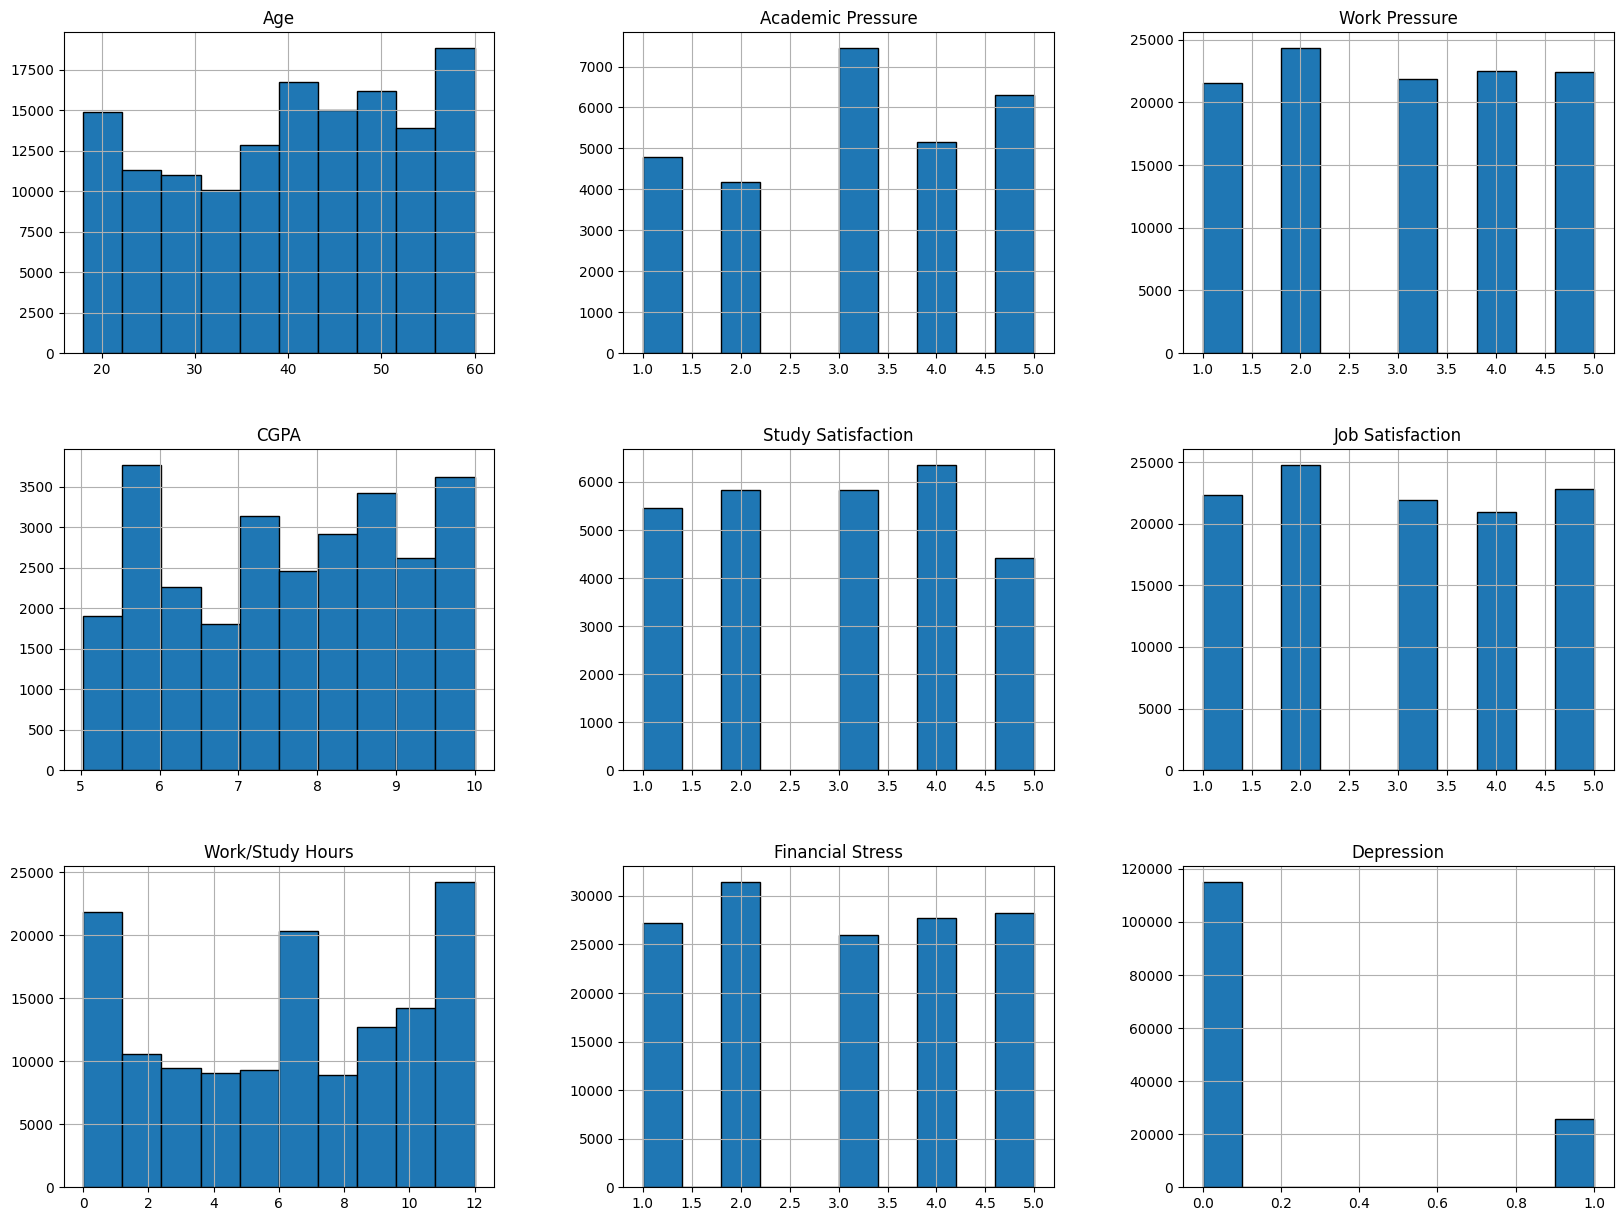

In [14]:
train_df.hist(figsize=(20,15),edgecolor='black');

In [15]:
#train_df.info()

In [16]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


### Target Variable

In [17]:
#train_df['Depression'].hist(figsize=(6,4));

In [18]:
#def cat_count_plot_dist(data,column,title=None,figsize=(15,10)):

In [19]:
def cat_plot_count_dist(data, column, title=None, figsize=(15,10)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data)
    
    # Set title (use column name if title not provided)
    title = title or f'Distribution by {column}'
    plt.title(title, fontsize=16)
    
    # Set labels
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Set tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fontsize=14, padding=10)
        
    plt.tight_layout()
    plt.show()

In [20]:
def plot_pie_distribution(data, column, explode=None, figsize=(6,6), title=None):
   # Get value counts
   counts = data[column].value_counts()
   
   # Set default explode if not provided 
   if explode is None:
       explode = tuple([0] * len(counts))
   
   # Set default title if not provided
   title = title or f'Distribution of {column}'
   
   plt.figure(figsize=figsize)
   plt.pie(counts.values, labels=counts.index,
           explode=explode, autopct='%1.1f%%', startangle=90)
   plt.axis('equal')
   plt.title(title, fontsize=16)
   plt.show()


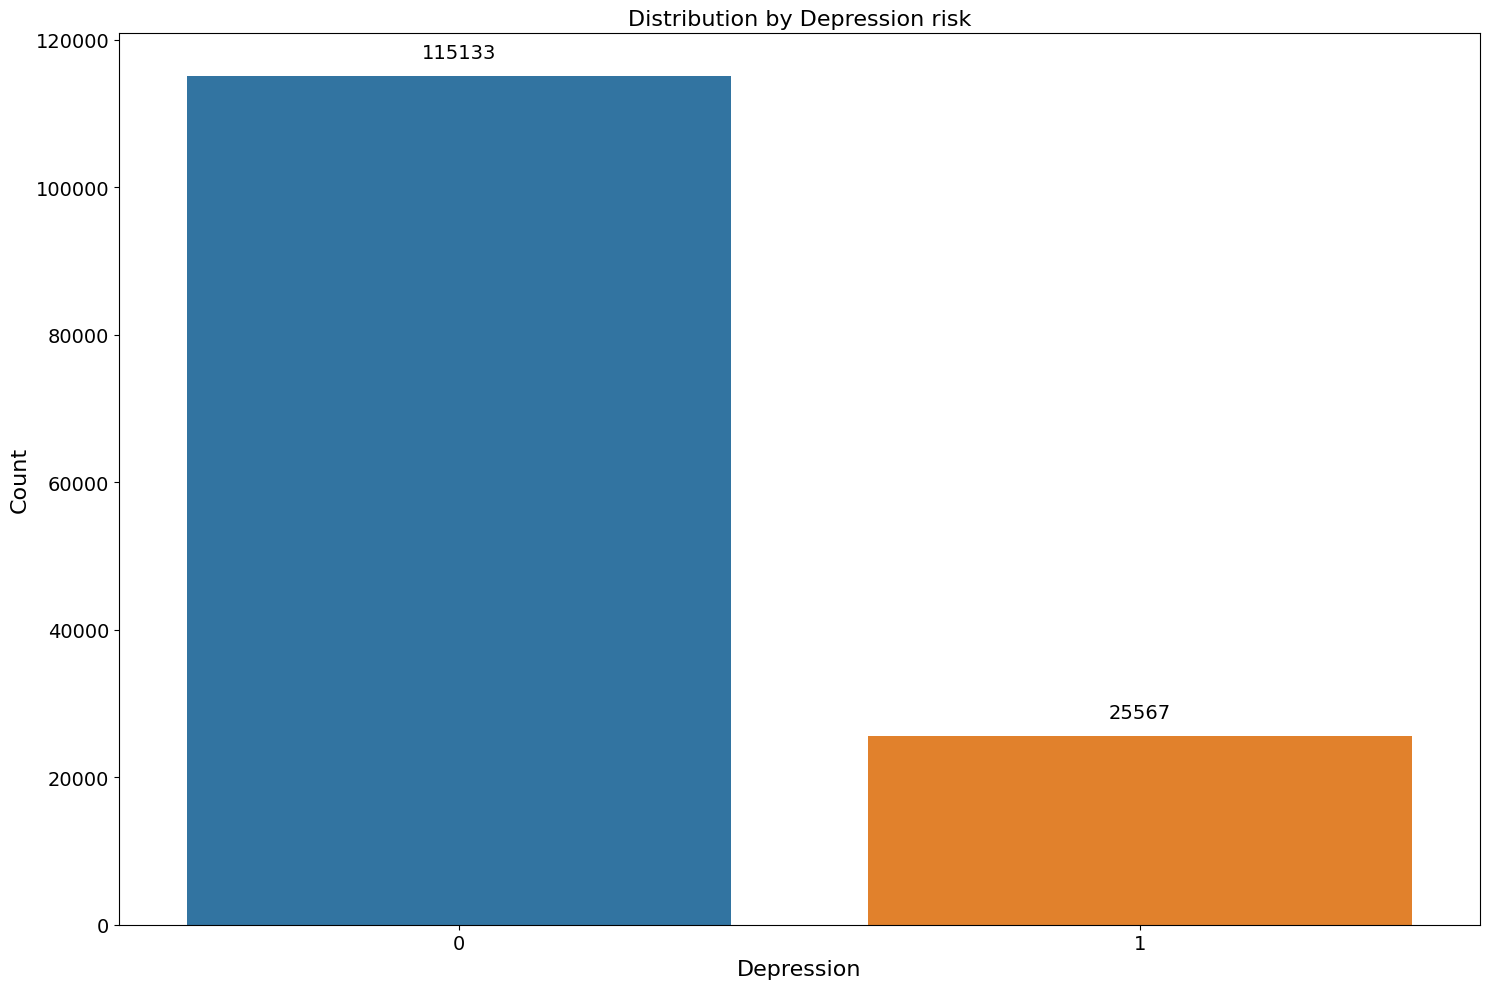

In [21]:
#cat_plot_count_dist(train_df, 'Depression', figsize=(12,8))
cat_plot_count_dist(train_df, 'Depression', 'Distribution by Depression risk')

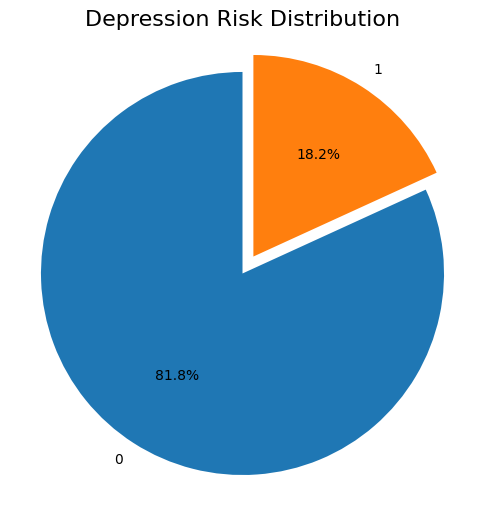

In [22]:
plot_pie_distribution(train_df, 'Depression', 
                    explode=(0,0.1), 
                    title='Depression Risk Distribution')

We can see from above that the dataset is imbalanced.

### Univariate Analysis

Let us take a look at the categorical variables shown by adding include=[object] below

In [23]:
train_df.describe(include=[object]).T

,count,unique,top,freq
Name,140700,422,Rohan,3178
Gender,140700,2,Male,77464
City,140700,98,Kalyan,6591
Working Professional or Student,140700,2,Working Professional,112799
Profession,104070,64,Teacher,24906
Sleep Duration,140700,36,Less than 5 hours,38784
Dietary Habits,140696,23,Moderate,49705
Degree,140698,115,Class 12,14729
Have you ever had suicidal thoughts ?,140700,2,No,71138
Family History of Mental Illness,140700,2,No,70758


#### Name

In [24]:
train_df['Name'].nunique()

422

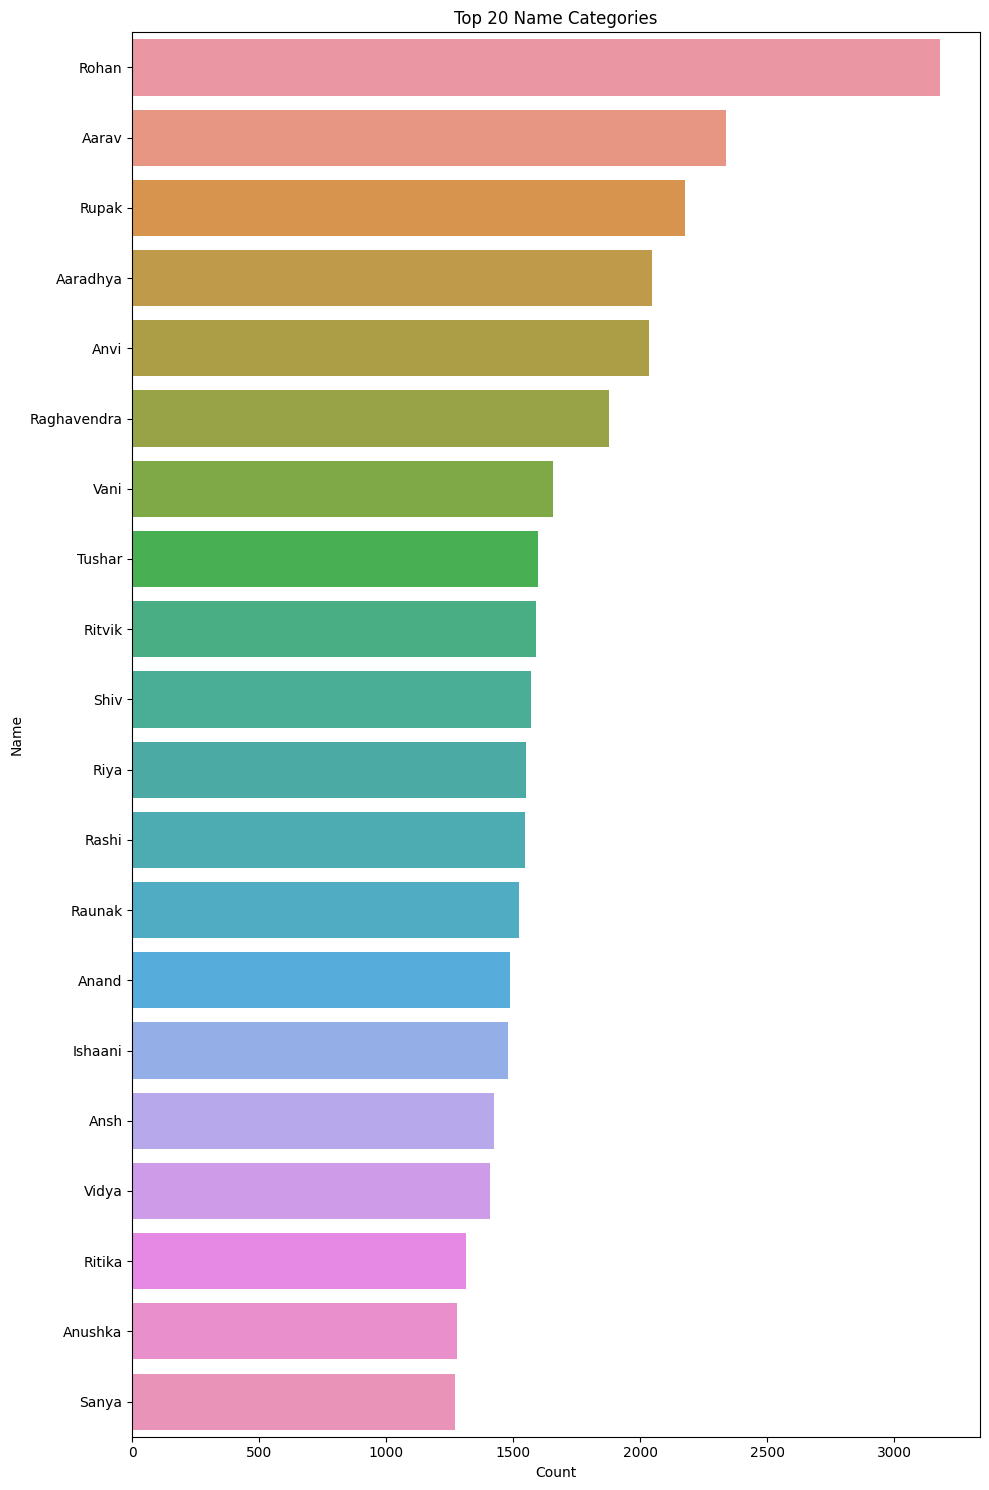

In [25]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Name', top_n=20)

It seems that Rohan in quite the popular name.

Personally i have a feeling name isnt a big influencing factor as you are named at before or at birth, but we can look at the model feature importance below for more conclusive evidence.

After taking a look at the feature importance for the various models below, it does seem to actually be an important variable. I wonder why name would be an important factor. I will try to look into this later on.

#### Gender

In [26]:
train_df['Gender'].unique(),train_df['Gender'].nunique()

(array(['Female', 'Male'], dtype=object), 2)

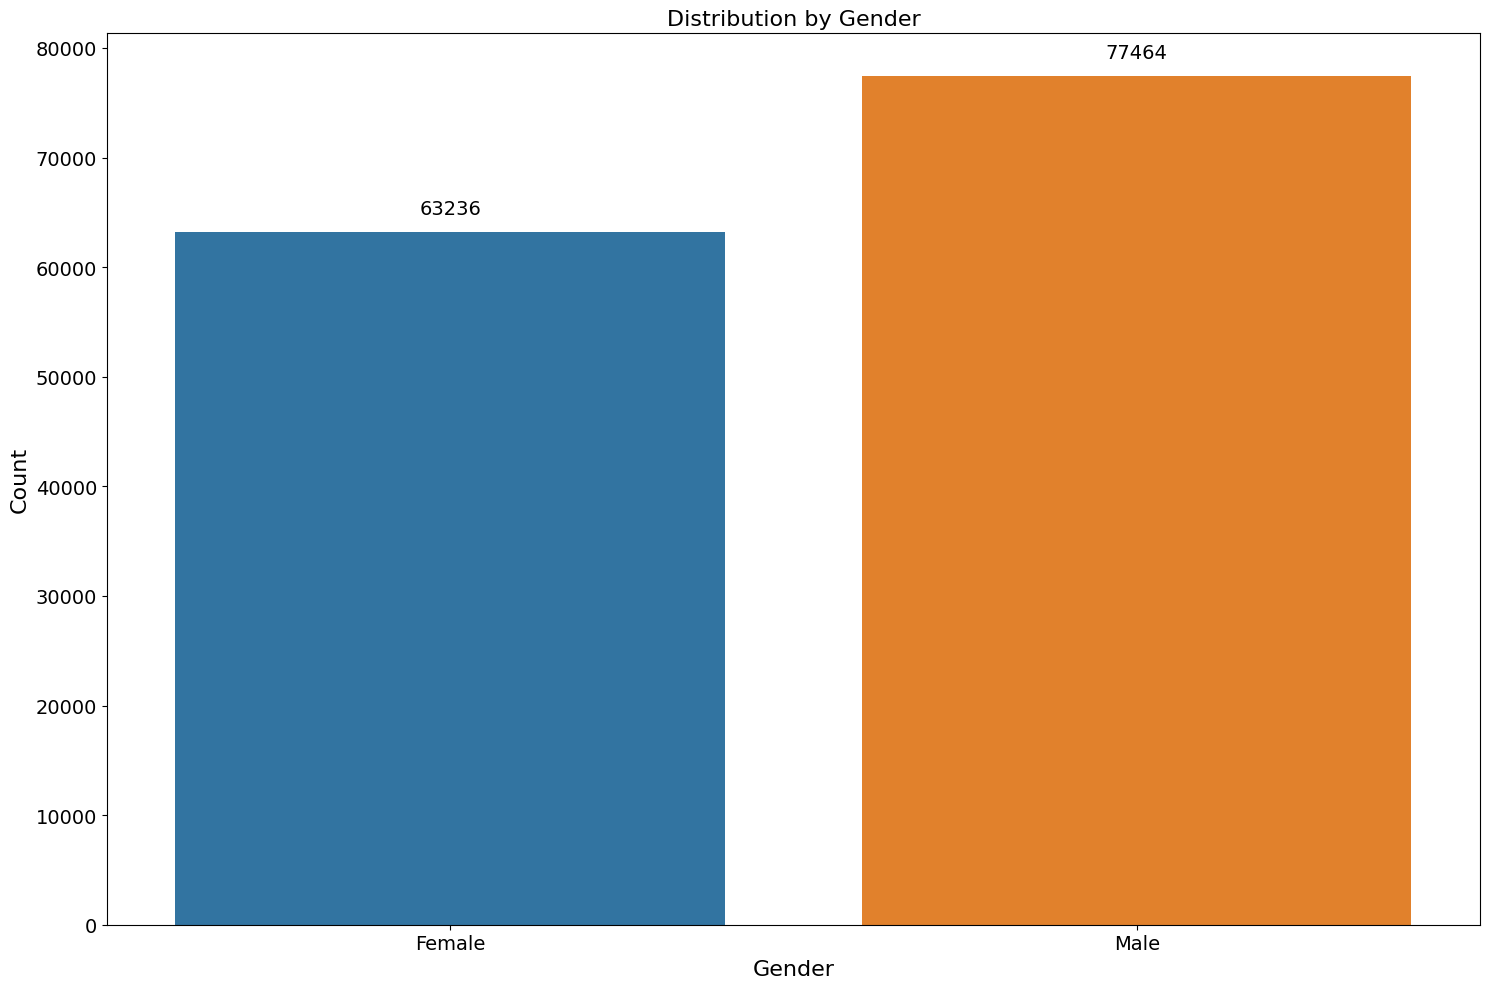

In [27]:
cat_plot_count_dist(train_df, 'Gender', 'Distribution by Gender')

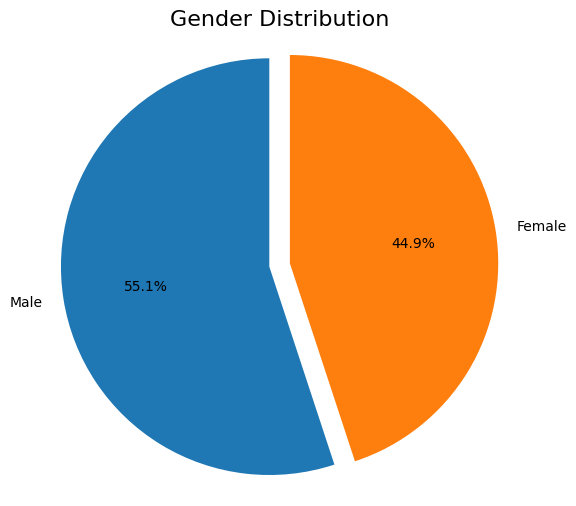

In [28]:
plot_pie_distribution(train_df, 'Gender', 
                    explode=(0,0.1), 
                    title='Gender Distribution')

The dataset has almost as many women as men potentially reducing the bias caused by class imbalance.

## Data Pre-processing with fast.ai



In [29]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Depression',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

I will explain what is going on above

- First we define categorical and continous variables
I use the fastai cont_cat_split function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

- Split into training and validation set
The RandomSplitter below separates the training set into a training and validation set based off the value of the argument valid_pct.

- Define a TabularPandas object.
Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

- Create and define a dataloaders
This prepares our data for input into our neural network.Here we can define our batch size.

- Extract train and validation sets + their values.


In [30]:
cont_names,len(cont_names)

(['Age',
  'Academic Pressure',
  'Work Pressure',
  'CGPA',
  'Study Satisfaction',
  'Job Satisfaction',
  'Work/Study Hours',
  'Financial Stress'],
 8)

In [31]:
cat_names,len(cat_names)

(['Name',
  'Gender',
  'City',
  'Working Professional or Student',
  'Profession',
  'Sleep Duration',
  'Dietary Habits',
  'Degree',
  'Have you ever had suicidal thoughts ?',
  'Family History of Mental Illness',
  'Academic Pressure_na',
  'Work Pressure_na',
  'CGPA_na',
  'Study Satisfaction_na',
  'Job Satisfaction_na',
  'Financial Stress_na'],
 16)

In [32]:
train_df.shape,X_train.shape

((140700, 19), (112560, 24))

It seems the preprocessing steps from above result in new columns in my training data, X_train

# Models

In [33]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_preds = {'random_state':42}

## Cross Validation function

In [34]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks

In [35]:
learn = tabular_learner(dls, metrics=accuracy)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.001737800776027143)

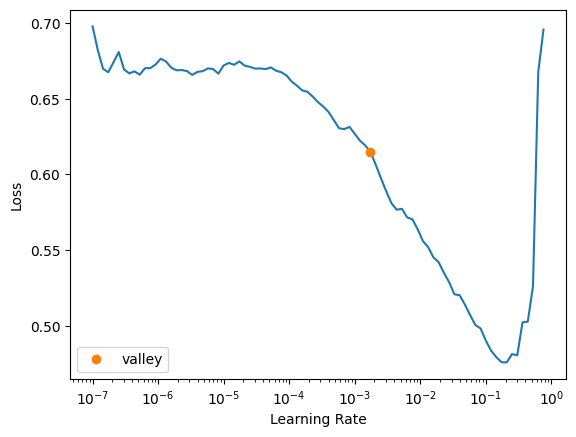

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.174278,0.165521,0.937313,00:29
1,0.158072,0.160992,0.936567,00:29
2,0.159713,0.158365,0.936532,00:31
3,0.143102,0.158298,0.937633,00:29
4,0.153526,0.159621,0.937740,00:29
5,0.139076,0.160382,0.937349,00:29
6,0.131671,0.165731,0.935999,00:29
7,0.130117,0.167352,0.935039,00:29
8,0.124134,0.166420,0.934790,00:28
9,0.118593,0.166350,0.934471,00:29


In [38]:
dl = test_dl

In [39]:
learn.save('nn_model_mental_health_v1')

Path('models/nn_model_mental_health_v1.pth')

In [40]:
#learn.load('nn_model_loan_approval_v1')  

In [41]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [42]:
a_preds.shape

torch.Size([93800, 2])

In [43]:
nn_preds_y.shape,sub_df.shape

(torch.Size([93800, 2]), (93800, 2))

In [44]:
final_preds = torch.round(a_preds).long()
final_preds

tensor([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]])

In [45]:
final_preds.shape

torch.Size([93800, 2])

In [46]:
!rm submission.csv
#sub_df['Depression'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## Gradient Boosting

In [47]:
# Parameters

## Random Forest

In [48]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 3min 13s, sys: 711 ms, total: 3min 14s
Wall time: 3min 14s


0.9371712864250178

In [49]:
rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0], dtype=torch.int8)

In [50]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.935590
Fold 2 AUC: 0.937367
Fold 3 AUC: 0.936167
Fold 4 AUC: 0.936656
Fold 5 AUC: 0.937189

Mean AUC: 0.936594


In [51]:
rf_oof_preds

array([0., 0., 0., ..., 0., 0., 1.])

In [52]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [53]:
 rf_mean_score

0.9365938166311301

In [54]:
rf_fold_scores

[0.935589907604833,
 0.9373667377398721,
 0.9361673773987207,
 0.9366560056858564,
 0.9371890547263682]

In [55]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((112560,), torch.Size([93800]), 0.9365938166311301)

Random forest feature importance

In [56]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [57]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
16,Age,2.154649e-01
8,Have you ever had suicidal thoughts ?,1.244911e-01
4,Profession,9.055057e-02
17,Academic Pressure,6.380703e-02
23,Financial Stress,5.427732e-02
11,Work Pressure_na,4.426260e-02
12,CGPA_na,3.949192e-02
10,Academic Pressure_na,3.801988e-02
22,Work/Study Hours,3.601235e-02
0,Name,3.046126e-02


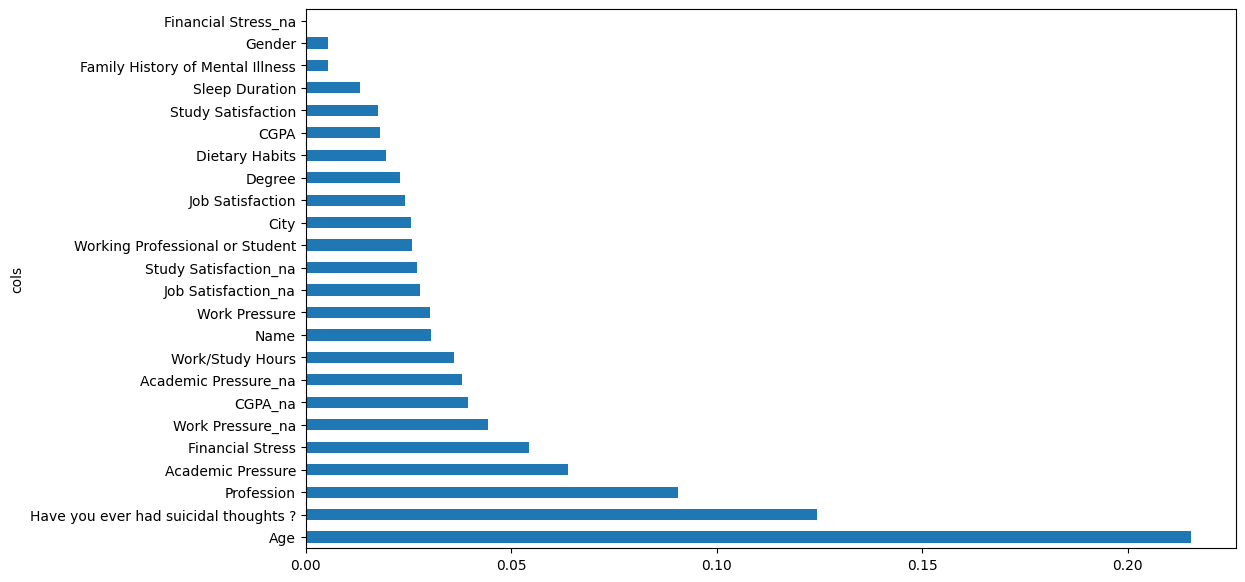

In [58]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [59]:
!rm submission.csv
#sub_df['Depression'] = rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## XGBoost

#### Single Fold

In [60]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 4.27 s, sys: 44 ms, total: 4.32 s
Wall time: 2.23 s


0.9374200426439232

In [61]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier,
    model_params = xgb_params
)

Fold 1 AUC: 0.937011
Fold 2 AUC: 0.936834
Fold 3 AUC: 0.937100
Fold 4 AUC: 0.937145
Fold 5 AUC: 0.937633

Mean AUC: 0.937145


In [62]:
xgb_oof_preds

array([0., 0., 0., ..., 0., 0., 1.])

In [63]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds 

tensor([0, 0, 0,  ..., 0, 1, 0])

In [64]:
xgb_mean_score

0.9371446339729923

In [65]:
xgb_fold_scores

[0.9370113717128643,
 0.9368336886993603,
 0.9371002132196162,
 0.9371446339729922,
 0.9376332622601279]

In [66]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((112560,), torch.Size([93800]), 0.9371446339729923)

In [67]:
!rm submission.csv
#sub_df['Depression'] = submission_preds 
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


In [68]:
#%%time
#K_FOLDS = 10  # Number of folds for cross-validation
#skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
#xgb_fold_scores = []

# Array to store out-of-fold predictions
#oof_predictions = np.zeros(len(X_train))

#for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    #X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    #y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    #xgb_model_fold = xgb.XGBClassifier()
    #xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    #y_pred_fold = xgb_model_fold.predict(X_fold_val)
    #y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    #xgb_cv_score = accuracy_score(y_fold_val, y_pred_fold)
    #xgb_fold_scores.append(xgb_cv_score)
    
    #print(f"Fold {fold} AUC: {xgb_cv_score}")

# Calculate and print the mean score across all folds
#xgb_mean_score = np.mean(xgb_fold_scores)
#print(f"Mean AUC: {xgb_mean_score}")

Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

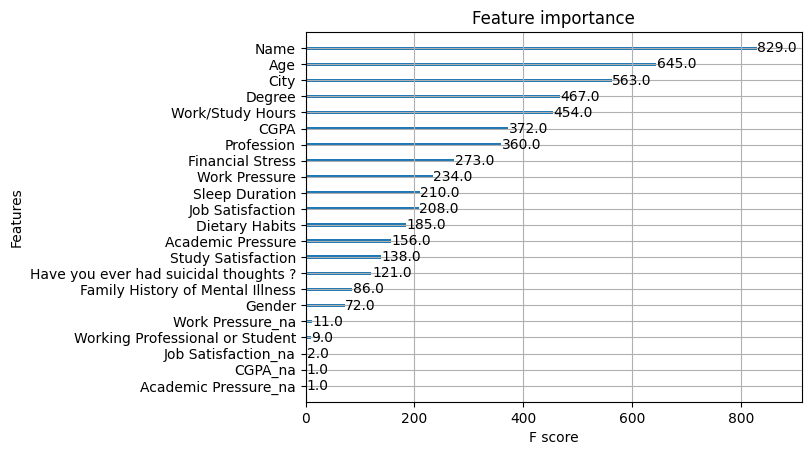

In [69]:
plot_importance(xgb_model)

## LGBM

In [70]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20489, number of negative: 92071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182027 -> initscore=-1.502672
[LightGBM] [Info] Start training from score -1.502672
CPU times: user 4.56 s, sys: 64 ms, total: 4.62 s
Wall time: 2.43 s


0.9380952380952381

In [71]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier,
    model_params = lgbm_params
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16392, number of negative: 73656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 90048, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182036 -> initscore=-1.502612
[LightGBM] [Info] Start training from score -1.502612
Fold 1 AUC: 0.938522
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16391, number of negative: 73657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

In [72]:
lgbm_oof_preds

array([0., 0., 0., ..., 0., 0., 1.])

In [73]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [74]:
lgbm_mean_score

0.938814854299929

In [75]:
lgbm_fold_scores

[0.9385216773276475,
 0.9388770433546553,
 0.9389658848614072,
 0.9397210376687989,
 0.9379886282871357]

In [76]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((112560,), torch.Size([93800]), 0.938814854299929)

In [77]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18441, number of negative: 82863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 101304, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182036 -> initscore=-1.502612
[LightGBM] [Info] Start training from score -1.502612
Fold 1 AUC: 0.9403873489694385
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18440, number of negative: 82864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

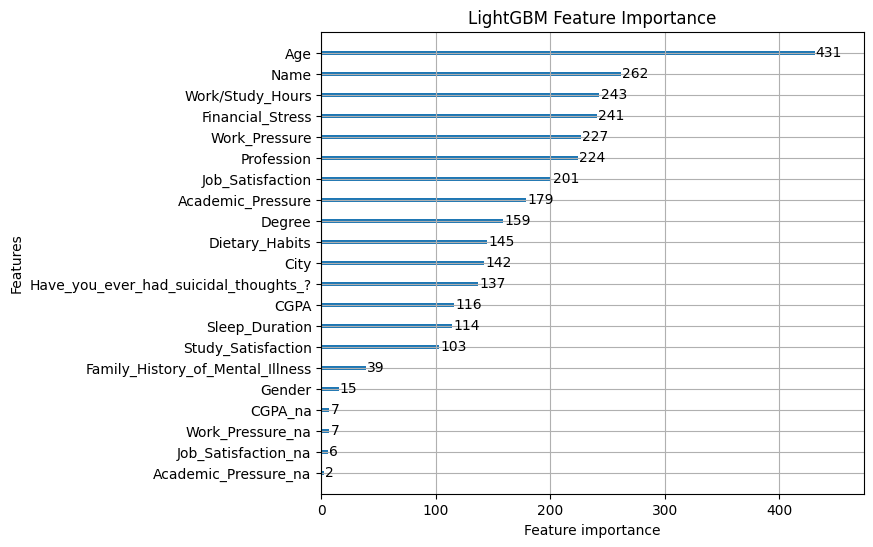

In [78]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

## CatBoost

In [79]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 1min 17s, sys: 4.79 s, total: 1min 22s
Wall time: 21.9 s


0.9388770433546553

In [80]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier,
    model_params = cat_params
)

Learning rate set to 0.070387
0:	learn: 0.5769913	total: 19.2ms	remaining: 19.2s
1:	learn: 0.4884481	total: 37.4ms	remaining: 18.7s
2:	learn: 0.4209007	total: 55.9ms	remaining: 18.6s
3:	learn: 0.3690602	total: 74.2ms	remaining: 18.5s
4:	learn: 0.3318100	total: 91.4ms	remaining: 18.2s
5:	learn: 0.3025208	total: 110ms	remaining: 18.2s
6:	learn: 0.2795456	total: 130ms	remaining: 18.4s
7:	learn: 0.2611213	total: 149ms	remaining: 18.5s
8:	learn: 0.2454299	total: 168ms	remaining: 18.5s
9:	learn: 0.2341055	total: 186ms	remaining: 18.4s
10:	learn: 0.2241296	total: 208ms	remaining: 18.7s
11:	learn: 0.2162163	total: 225ms	remaining: 18.5s
12:	learn: 0.2098825	total: 243ms	remaining: 18.4s
13:	learn: 0.2040647	total: 261ms	remaining: 18.3s
14:	learn: 0.1992597	total: 279ms	remaining: 18.3s
15:	learn: 0.1960218	total: 295ms	remaining: 18.2s
16:	learn: 0.1925856	total: 314ms	remaining: 18.1s
17:	learn: 0.1893801	total: 331ms	remaining: 18.1s
18:	learn: 0.1865793	total: 349ms	remaining: 18s
19:	lear

In [81]:
cat_oof_preds

array([0., 0., 0., ..., 0., 0., 1.])

In [82]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [83]:
cat_mean_score

0.9395344705046197

In [84]:
cat_fold_scores

[0.939276830135039,
 0.9401208244491827,
 0.939410092395167,
 0.9408759772565742,
 0.9379886282871357]

In [85]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((112560,), torch.Size([93800]), 0.9395344705046197)

In [86]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.074018
0:	learn: 0.5742878	total: 21.7ms	remaining: 21.7s
1:	learn: 0.4845331	total: 42.6ms	remaining: 21.2s
2:	learn: 0.4207902	total: 62.5ms	remaining: 20.8s
3:	learn: 0.3684764	total: 83.3ms	remaining: 20.7s
4:	learn: 0.3312046	total: 105ms	remaining: 21s
5:	learn: 0.3006795	total: 126ms	remaining: 20.8s
6:	learn: 0.2768320	total: 145ms	remaining: 20.6s
7:	learn: 0.2573665	total: 166ms	remaining: 20.5s
8:	learn: 0.2427411	total: 187ms	remaining: 20.6s
9:	learn: 0.2323285	total: 207ms	remaining: 20.5s
10:	learn: 0.2231585	total: 227ms	remaining: 20.5s
11:	learn: 0.2156563	total: 247ms	remaining: 20.3s
12:	learn: 0.2082259	total: 266ms	remaining: 20.2s
13:	learn: 0.2026821	total: 284ms	remaining: 20s
14:	learn: 0.1989770	total: 303ms	remaining: 19.9s
15:	learn: 0.1952945	total: 322ms	remaining: 19.8s
16:	learn: 0.1924280	total: 341ms	remaining: 19.7s
17:	learn: 0.1893564	total: 364ms	remaining: 19.8s
18:	learn: 0.1870385	total: 383ms	remaining: 19.8s
19:	learn: 

In [87]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Name, Importance: 4.27
Feature: Gender, Importance: 0.62
Feature: Age, Importance: 2.68
Feature: City, Importance: 0.08
Feature: Working Professional or Student, Importance: 4.66
Feature: Profession, Importance: 2.54
Feature: Academic Pressure, Importance: 2.97
Feature: Work Pressure, Importance: 2.39
Feature: CGPA, Importance: 14.46
Feature: Study Satisfaction, Importance: 0.95
Feature: Job Satisfaction, Importance: 0.03
Feature: Sleep Duration, Importance: 0.12
Feature: Dietary Habits, Importance: 0.00
Feature: Degree, Importance: 0.02
Feature: Have you ever had suicidal thoughts ?, Importance: 0.43
Feature: Work/Study Hours, Importance: 0.00
Feature: Financial Stress, Importance: 29.93
Feature: Family History of Mental Illness, Importance: 3.74
Feature: Depression, Importance: 8.16


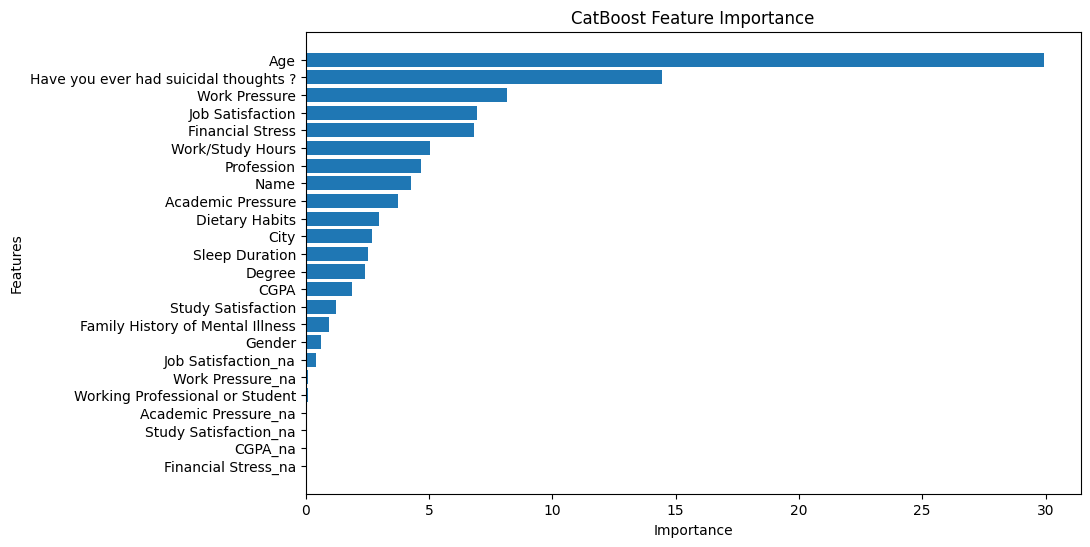

In [88]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [89]:
!rm submission.csv
#sub_df['Depression'] = cat_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


# Ensembling

## Averaging

### Scoring

In [90]:
def average_preds_score(preds_a,preds_b):
    average_preds = (torch.round(preds_a + preds_b)/2).long()
    preds_score = accuracy_score(y_test,average_preds)
    print(f"Average_score:{preds_score}")
    return preds_score

In [91]:
xgb_lgbm_score = average_preds_score(xgb_preds_x,lgbm_preds_x)
xgb_lgbm_score

Average_score:0.9384861407249467


0.9384861407249467

In [92]:
cat_lgbm_score = average_preds_score(cat_preds_x,lgbm_preds_x)
cat_lgbm_score

Average_score:0.938770433546553


0.938770433546553

In [93]:
cat_xgb_score = average_preds_score(cat_preds_x,xgb_preds_x)
cat_xgb_score

Average_score:0.9390191897654584


0.9390191897654584

In [94]:
cat_rf_score = average_preds_score(cat_preds_x,rf_preds_x)
cat_rf_score

Average_score:0.9380597014925374


0.9380597014925374

In [95]:
lgbm_rf_score = average_preds_score(lgbm_preds_x,rf_preds_x)
lgbm_rf_score

Average_score:0.9377043354655294


0.9377043354655294

In [96]:
xgb_rf_score = average_preds_score(xgb_preds_x,rf_preds_x)
xgb_rf_score

Average_score:0.9374911158493248


0.9374911158493248

In [97]:
cat_xgb_lgbm_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x)/3
cat_xgb_lgbm_preds_x = torch.round(cat_xgb_lgbm_preds_x).long()
cat_xgb_lgbm_score = accuracy_score(y_test,cat_xgb_lgbm_preds_x)

In [98]:
cat_xgb_lgbm_rf_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x + rf_preds_x)/4
cat_xgb_lgbm_rf_preds_x = torch.round(cat_xgb_lgbm_rf_preds_x).long()
cat_xgb_lgbm_rf_score = accuracy_score(y_test,cat_xgb_lgbm_rf_preds_x)

## Submission

In [99]:
def average_preds_sub(preds_a,preds_b):
    average_preds_sub = (torch.round(preds_a + preds_b)/2).long()
    return average_preds_sub

In [100]:
cat_lgbm_preds = average_preds_sub(cat_preds,lgbm_preds)
cat_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [101]:
cat_xgb_preds = average_preds_sub(cat_preds,xgb_preds)
cat_xgb_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [102]:
xgb_lgbm_preds = average_preds_sub(xgb_preds,lgbm_preds)
xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [103]:
cat_xgb_lgbm_preds = (cat_preds + xgb_preds + lgbm_preds)/3
cat_xgb_lgbm_preds = torch.round(cat_xgb_lgbm_preds).long()
cat_xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [104]:
cat_xgb_lgbm_rf_preds = (cat_preds + xgb_preds + lgbm_preds + rf_preds)/4
cat_xgb_lgbm_rf_preds = torch.round(cat_xgb_lgbm_rf_preds).long()
cat_xgb_lgbm_rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [105]:
#!rm submission.csv
#sub_df['Depression'] = cat_xgb_lgbm_rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

## Hill Climbing

Below, i try to create a weighted ensemble using hill climbing, first i shall try for lgbm and catboost which are my best performing models so far

In [106]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.4994995 0.5005005]
Best validation accuracy: 0.9388770433546553

Model Scores:
LightGBM: 0.9380952380952381
CatBoost: 0.9388770433546553
Hill Climbing Ensemble: 0.9388770433546553


Hill climbing and catboost score seem to be the same, did it just selcet cat scores ?

add something to show model contribution percentage

In [107]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    # Calculate percentage contributions
    percentages = {
        'LightGBM': weights[0] * 100,
        'CatBoost': weights[1] * 100
    }
    
    return valid_preds, test_preds, weights, best_score, percentages

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score, model_percentages = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print("\nModel Contributions:")
for model, percentage in model_percentages.items():
    print(f"{model}: {percentage:.2f}%")

print(f"\nBest validation accuracy: {best_score}")

# Compare scores
print("\nIndividual Model Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)


Model Contributions:
LightGBM: 49.95%
CatBoost: 50.05%

Best validation accuracy: 0.9388770433546553

Individual Model Scores:
LightGBM: 0.9380952380952381
CatBoost: 0.9388770433546553
Hill Climbing Ensemble: 0.9388770433546553


xgb + lgbm + cat

In [108]:
# Get both probabilities and class predictions
xgb_preds = tensor(xgb_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
xgb_valid_preds = tensor(xgb_model.predict(X_test))
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'xgb': xgb_valid_preds,
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'xgb': xgb_preds,
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"XGBoost: {xgb_score}")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.33333333 0.33333333 0.33333333]
Best validation accuracy: 0.9388059701492537

Model Scores:
XGBoost: 0.9374200426439232
LightGBM: 0.9380952380952381
CatBoost: 0.9388770433546553
Hill Climbing Ensemble: 0.9388059701492537


In [109]:
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Stacking

In [110]:
stacking_estimators = [
    ('cat_boost',cat_model),
    #('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

stacking_classifier_cat_xgb_lgbm= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_xgb_lgbm.fit(X_train, y_train)


stacking_preds_cat_xgb_lgbm = (stacking_classifier_cat_xgb_lgbm.predict(test_dl.xs))
stacking_preds_cat_xgb_lgbm_x = stacking_classifier_cat_xgb_lgbm.predict(X_test)

stacking_score_cat_xgb_lgbm = accuracy_score(y_test, stacking_preds_cat_xgb_lgbm_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_xgb_lgbm}")

Learning rate set to 0.077424
0:	learn: 0.5693794	total: 23.7ms	remaining: 23.6s
1:	learn: 0.4768997	total: 43.6ms	remaining: 21.7s
2:	learn: 0.4125114	total: 64.7ms	remaining: 21.5s
3:	learn: 0.3597748	total: 87.7ms	remaining: 21.8s
4:	learn: 0.3200023	total: 110ms	remaining: 21.9s
5:	learn: 0.2906800	total: 132ms	remaining: 21.8s
6:	learn: 0.2692648	total: 153ms	remaining: 21.7s
7:	learn: 0.2539575	total: 175ms	remaining: 21.7s
8:	learn: 0.2391919	total: 200ms	remaining: 22.1s
9:	learn: 0.2286871	total: 220ms	remaining: 21.8s
10:	learn: 0.2185787	total: 242ms	remaining: 21.8s
11:	learn: 0.2112743	total: 264ms	remaining: 21.7s
12:	learn: 0.2056423	total: 284ms	remaining: 21.6s
13:	learn: 0.2014223	total: 305ms	remaining: 21.5s
14:	learn: 0.1962571	total: 326ms	remaining: 21.4s
15:	learn: 0.1927576	total: 347ms	remaining: 21.3s
16:	learn: 0.1894357	total: 367ms	remaining: 21.2s
17:	learn: 0.1863904	total: 388ms	remaining: 21.2s
18:	learn: 0.1842512	total: 416ms	remaining: 21.5s
19:	lea

In [111]:
stacking_preds_cat_xgb_lgbm.shape

(93800,)

In [112]:
stacking_preds_cat_xgb_lgbm = torch.tensor(stacking_preds_cat_xgb_lgbm)

In [113]:
#!rm submission.csv
#sub_df['Depression'] = stacking_preds_cat_xgb_lgbm
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

In the next version ill try out voting and compare performance

### Voting

In [114]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='soft')



voting_clf.fit(X_train, y_train)

voting_predictions = voting_clf.predict(test_dl.xs)
voting_predictions_x = voting_clf.predict(X_test)

# Calculate the accuracy score
voting_accuracy_soft = accuracy_score(y_test, voting_predictions_x)
#print(f"Accuracy: {voting_accuracy:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5693794	total: 22.4ms	remaining: 22.4s
1:	learn: 0.4768997	total: 42ms	remaining: 21s
2:	learn: 0.4125114	total: 63.4ms	remaining: 21.1s
3:	learn: 0.3597748	total: 86.5ms	remaining: 21.5s
4:	learn: 0.3200023	total: 109ms	remaining: 21.6s
5:	learn: 0.2906800	total: 130ms	remaining: 21.6s
6:	learn: 0.2692648	total: 151ms	remaining: 21.5s
7:	learn: 0.2539575	total: 173ms	remaining: 21.5s
8:	learn: 0.2391919	total: 197ms	remaining: 21.7s
9:	learn: 0.2286871	total: 217ms	remaining: 21.5s
10:	learn: 0.2185787	total: 238ms	remaining: 21.4s
11:	learn: 0.2112743	total: 260ms	remaining: 21.4s
12:	learn: 0.2056423	total: 281ms	remaining: 21.3s
13:	learn: 0.2014223	total: 303ms	remaining: 21.3s
14:	learn: 0.1962571	total: 325ms	remaining: 21.3s
15:	learn: 0.1927576	total: 346ms	remaining: 21.3s
16:	learn: 0.1894357	total: 366ms	remaining: 21.1s
17:	learn: 0.1863904	total: 387ms	remaining: 21.1s
18:	learn: 0.1842512	total: 409ms	remaining: 21.1s
19:	learn: 

In [115]:
voting_accuracy_soft

0.9389125799573561

In [116]:
voting_predictions.shape

(93800,)

In [117]:
voting_predictions = torch.tensor(voting_predictions)

I also try with voting = hard

In [118]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf_hard = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='hard')



voting_clf_hard.fit(X_train, y_train)

voting_predictions_hard = voting_clf_hard.predict(test_dl.xs)
voting_predictions_hard_x = voting_clf_hard.predict(X_test)

# Calculate the accuracy score
voting_accuracy_hard = accuracy_score(y_test, voting_predictions_hard_x)
print(f"Accuracy: {voting_accuracy_hard:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5693794	total: 24.1ms	remaining: 24s
1:	learn: 0.4768997	total: 44.2ms	remaining: 22s
2:	learn: 0.4125114	total: 65.4ms	remaining: 21.7s
3:	learn: 0.3597748	total: 87.6ms	remaining: 21.8s
4:	learn: 0.3200023	total: 109ms	remaining: 21.7s
5:	learn: 0.2906800	total: 131ms	remaining: 21.6s
6:	learn: 0.2692648	total: 153ms	remaining: 21.7s
7:	learn: 0.2539575	total: 174ms	remaining: 21.6s
8:	learn: 0.2391919	total: 199ms	remaining: 21.9s
9:	learn: 0.2286871	total: 221ms	remaining: 21.9s
10:	learn: 0.2185787	total: 245ms	remaining: 22s
11:	learn: 0.2112743	total: 266ms	remaining: 21.9s
12:	learn: 0.2056423	total: 287ms	remaining: 21.8s
13:	learn: 0.2014223	total: 307ms	remaining: 21.6s
14:	learn: 0.1962571	total: 328ms	remaining: 21.6s
15:	learn: 0.1927576	total: 350ms	remaining: 21.5s
16:	learn: 0.1894357	total: 370ms	remaining: 21.4s
17:	learn: 0.1863904	total: 392ms	remaining: 21.4s
18:	learn: 0.1842512	total: 416ms	remaining: 21.5s
19:	learn: 0.

# Final Submission

In [119]:
!rm submission.csv
sub_df['Depression'] = voting_predictions
sub_df.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Ranking performance

In [120]:
accuracy = pd.DataFrame({
    'algorithm': [ 'XGBoost','XGBoost CV','LGBM','LGBM CV',
                  'CatBoost','CatBoost CV','Random Forest',
                  'RF CV','XGB + LGBM', 'CAT + LGBM',
                  'CAT + XGB', 'CAT + XGB + LGBM',
                  'CAT + XGB + LGBM + RF','CAT + RF',
                  'LGBM + RF','XGB + RF','Hill Climbing CAT+LGBM',
                  'Stacking','Voting Soft','Voting Hard'
                 ],
    'accuracy': [xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,rf_score,
                 rf_mean_score,xgb_lgbm_score,cat_lgbm_score,
                 cat_xgb_score,cat_xgb_lgbm_score,
                 cat_xgb_lgbm_rf_score,cat_rf_score,
                 lgbm_rf_score,xgb_rf_score,best_score,
                 stacking_score_cat_xgb_lgbm,voting_accuracy_soft,
                 voting_accuracy_hard
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
5,CatBoost CV,0.939534
17,Stacking,0.939410
12,CAT + XGB + LGBM + RF,0.939055
10,CAT + XGB,0.939019
18,Voting Soft,0.938913
4,CatBoost,0.938877
3,LGBM CV,0.938815
11,CAT + XGB + LGBM,0.938806
16,Hill Climbing CAT+LGBM,0.938806
19,Voting Hard,0.938806


# Conclusions

CatBoost so far seems to out perform other models
